# Project: Classifying Pixels of Satellite Images

The whole project is very closely related to the scientific article about the sattelite data:
Aybar, C., Ysuhuaylas, L., Loja, J. et al. CloudSEN12, a global dataset for semantic understanding of cloud and cloud shadow in Sentinel-2. Sci Data 9, 782 (2022). https://doi.org/10.1038/s41597-022-01878-2

Link to the dataset (we used only 01__ROI_0001__ROI_0023):
https://cloudsen12.github.io/download.html

Layers description:
https://www.nature.com/articles/s41597-022-01878-2/tables/3

#### The main aim of the project is to examine different approaches for training a model that classifies clouds in the satelite pictures.

For the training we are using ROI with a number less than or equal to 20. For testing our model we used ROI 21, 22 and 23.

In [2]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import os
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [3]:
DATASET_DIRECTORY = './data'
TEST_DATASET_DIRECTORY = './test_data'
IMG_PER_REG = 5
PIX_PER_IMG = 509**2

def read_image_patch_file(path):
    path = path
    with rasterio.open(path) as image:
        image_array = image.read()
    return image_array

def read_image_data(path):
    # Load features
    features = read_image_patch_file(os.path.join(path, 'S2L1C.tif'))
    features2 = read_image_patch_file(os.path.join(path, 'S2L2A.tif'))
    features3 = read_image_patch_file(os.path.join(path, 'S1.tif'))
    # Join features
    features = np.concatenate((features, features2, features3), axis=0)
    # Load labels
    labels = read_image_patch_file(os.path.join(path, 'labels/manual_hq.tif'))
    return features, labels

def load_all_images(dir):
    images = []
    labels = []
    list_regions = []
    
    for archive in os.listdir(dir):
        for region in os.listdir(dir + '/' + archive):
            list_regions.append(region)
            for image in os.listdir(dir + '/' + archive + '/' + region):
                features, label = read_image_data(os.path.join(dir, archive, region, image))
                images.append(features)
                labels.append(label) 

    images = np.array(images)
    labels = np.array(labels)
    images = np.moveaxis(images, 1, 3)
    
    images = images.reshape(-1, images.shape[-1])
    df = pd.DataFrame(images)
    labels = labels.reshape(-1, 1)
    df['label'] = labels

    # Change column types to int
    df = df.astype(int)

    # Reindexing the dataframe with ROIs and pixels
    region = []
    for roi in list_regions:
        region = region + [roi] * IMG_PER_REG * PIX_PER_IMG

    image = []
    for i in range(1, IMG_PER_REG + 1):
        image = image + [i] * PIX_PER_IMG

    image = image * len(list_regions)

    pixel = list(range(1, PIX_PER_IMG + 1)) * IMG_PER_REG * len(list_regions)

    multi_index = pd.MultiIndex.from_tuples(list(zip(region, image, pixel)), names=["region", "image", "pixel"])
    df.set_index(multi_index, inplace=True)
    
    S2L2A_names = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12", "AOT", "WVP", "TCI_R", "TCI_G", "TCI_B"]
    S2L2A_names = ("S2L2A_" + pd.Series(S2L2A_names)).tolist()
    S2L1C_names = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B10", "B11", "B12"]
    S2L1C_names = ("S2L1C_" + pd.Series(S2L1C_names)).tolist()
    S1C_names = ["VV", "VH", "angle"]
    S1C_names = ("S1C_" + pd.Series(S1C_names)).tolist()

    col = S2L2A_names + S2L1C_names + S1C_names + ["label"]
    col = dict(zip(range(0, len(col)+1), col))

    df.rename(columns = dict(col), inplace = True)

    print("Loaded " + str(len(list_regions)) + " Regions Of Interest.")
    return df

In [4]:
df = load_all_images(DATASET_DIRECTORY)
df

Loaded 20 Regions Of Interest.


S2L2A_B1  S2L2A_B2  S2L2A_B3  S2L2A_B4  S2L2A_B5  \
region   image pixel                                                      
ROI_0001 1     1           1621      1455      1450      1660      1870   
               2           1668      1503      1503      1750      1882   
               3           1668      1524      1536      1800      1882   
               4           1668      1527      1555      1833      1946   
               5           1668      1557      1567      1868      1946   
...                         ...       ...       ...       ...       ...   
ROI_0023 5     259077      2973      1973      2630      3061      3194   
               259078      2973      2062      2597      3091      3194   
               259079      2371      2099      2513      3086      3064   
               259080      2371      2074      2427      2960      3064   
               259081      2371      2018      2407      2867      2899   

                       S2L2A_B6  S2L2A_B7  S2L2A_B8  S2L2A_B8A  S2L2A_B9  ...  \
region   image pixel                                                      ...   
ROI_0001 1     1           2008      2127      2002       2236      1084  ...   
               2           2043      2184      2073       2264      1146  ...   
               3           2043      2184      2131       2264      1146  ...   
               4           2098      2222      2173       2308      1146  ...   
               5           2098      2222      2189       2308      1146  ...   
...                         ...       ...       ...        ...       ...  ...   
ROI_0023 5     259077      3346      3501      2861       3601      2213  ...   
               259078      3346      3501      2966       3601      2213  ...   
               259079      3170      3312      2849       3334      1515  ...   
               259080      3170      3312      2784       3334      1515  ...   
               259081      3000      3172      2716       3242      1515  ...   

                       S2L1C_B8  S2L1C_B8A  S2L1C_B9  S2L1C_B10  S2L1C_B11  \
region   image pixel                                                         
ROI_0001 1     1           2611        191       696        167        133   
               2           2686        191       696        179        142   
               3           2686        191       696        186        147   
               4           2770        191       696        191        150   
               5           2770        191       696        196        152   
...                         ...        ...       ...        ...        ...   
ROI_0023 5     259077      3721        146       532        255        255   
               259078      3721        146       532        254        254   
               259079      3481        146       613        255        255   
               259080      3481        146       613        255        255   
               259081      3325        146       749        255        255   

                       S2L1C_B12  S1C_VV  S1C_VH  S1C_angle  label  
region   image pixel                                                
ROI_0001 1     1              95     -22     -15         31      0  
               2             103     -24     -14         31      0  
               3             107     -28     -13         31      0  
               4             107     -29     -12         31      0  
               5             113     -29     -12         31      0  
...                          ...     ...     ...        ...    ...  
ROI_0023 5     259077        183     -25     -13         42      1  
               259078        199     -24     -15         42      1  
               259079        204     -22     -16         42      1  
               259080        200     -22     -16         42      1  
               259081        192     -22     -15         42      1  

[25908100 rows x 34 columns]

In [5]:
def sample_data(df, p_pixels):
    """
    Sample data from the dataframe.
    
    Args:
        df (pd.DataFrame): Dataframe with the data.
        n_images (int): Number of images from ROI to sample.
        p_pixels (float): Percentage of pixels from image to sample.
    """
    regions = df.index.levels[0]
    images = df.index.levels[1]
    pixels = pd.Series(df.index.levels[2]).sample(int(p_pixels*509**2))
    print(f"Sampling {int(p_pixels*509**2)} pixels from {len(images)} images from {len(regions)} regions.")
    df_sample = df.loc[regions, images, pixels]
    return df_sample

In [6]:
sampled_data = sample_data(df, 0.001)
sampled_data.shape

Sampling 259 pixels from 5 images from 20 regions.


(25900, 34)

# EDA

In [7]:
def plot_cloudiness(df, region_name, images = [1, 2, 3, 4, 5], kind="pie"):
    """Plots the cloudiness (cloud percentage) of a given region name (str), list of regions (list) or all of the regions (then type 'all' in the region_name).
    Then, it's possible to select which images should be considered by typing an integer from [1,2,3,4,5] or a list of integers.
    The parameter kind decides which kind of plot will be displayed ('bar', 'barh', 'pie')
    The function returns a Series with the percentage of each label in the decimal form 0.sth"""
    
    # Selecting appropriate data
    if(region_name == "all"):
        df_plot = df['label'].droplevel(0)
    elif(type(region_name) == list):
        df_plot = df['label'].loc[region_name].droplevel(0)
    else:
        df_plot = df['label'].loc[region_name]
    
    if images != [1, 2, 3, 4, 5]:
        df_plot = df_plot.loc[images]
    # Now we don't have to drop the index level because the function value_counts doesn't take an index form into account
    norm_values = df_plot.value_counts(normalize=True)

    # Setting labels
    norm_values.index = norm_values.index.map({0: "Clear", 1: "Thick Cloud", 2: "Thin Cloud", 3: "Cloud Shadow"})

    # Handling colors and title
    colors = norm_values.index.map({"Clear": "olivedrab", "Thick Cloud": "whitesmoke", "Thin Cloud": "darkseagreen", "Cloud Shadow": "dimgray"})
    
    if(region_name == "all"):
        plot_title = "Cloud percentage of all regions"
    elif(type(region_name) == list):
        plot_title = "Cloud percentage of the selected regions"
    else:
        plot_title = "Cloud percantage of the " + region_name
    
    if(images == [1,2,3,4,5]):
        plot_title = plot_title + " among all images"
    else:
        plot_title = plot_title + " among images: " + str(images).strip('[]')

    
    if(kind == "pie"):
        plt.pie(norm_values * 100, autopct='%1.1f%%', startangle=90, colors = colors, labels = norm_values.index);
        plt.title(plot_title)
        plt.show()
    
    elif(kind == "barh"):
        ax = (norm_values * 100).plot.barh(xlim = [0,100], xlabel = "Percentage", ylabel = "", title = plot_title,
                                           color = colors, edgecolor = "black", linewidth = 0.5)
        ax.bar_label(ax.containers[0], fmt='%1.1f%%', padding = 2)
        ax.invert_yaxis()

    elif(kind == "bar"):
        ax = (norm_values * 100).plot.bar(xlabel = "", ylim = [0,100], ylabel = "Percentage", title = plot_title,
                                          color = colors, edgecolor = "black", linewidth = 0.5)
        ax.bar_label(ax.containers[0], fmt='%1.1f%%')
        
    return norm_values

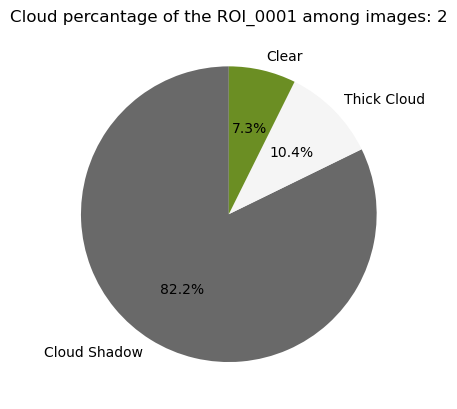

label
Cloud Shadow    0.822394
Thick Cloud     0.104247
Clear           0.073359
Name: proportion, dtype: float64


In [9]:
print(plot_cloudiness(sampled_data, "ROI_0001", images=2, kind = "pie"))

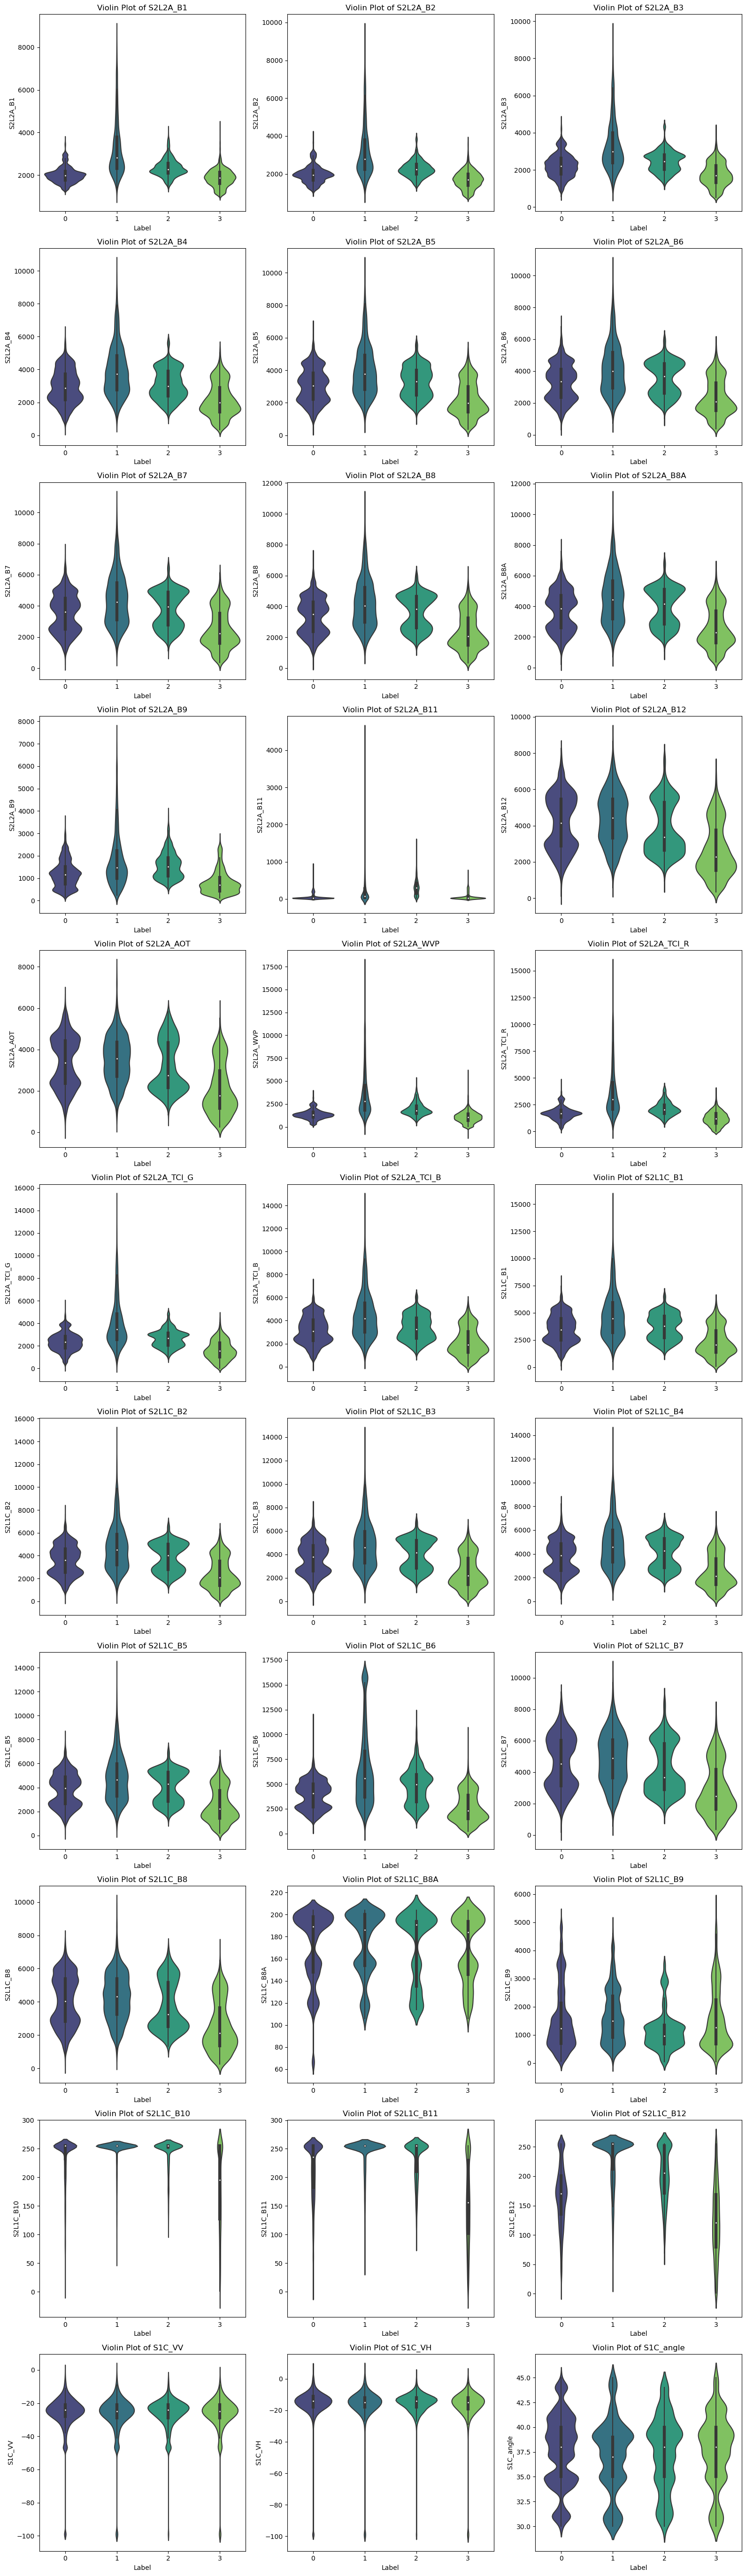

In [13]:
## We begin the Exploratory Data Analysis by showing a violin plot of each feature so will get a basic insight into the data distribution
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

features = sampled_data.drop('label', axis=1)

num_features = len(features.columns)
num_rows = (num_features // 3) + (num_features % 3)
num_cols = 3

plt.figure(figsize=(16, 5 * num_rows))
for i, feature in enumerate(features.columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.violinplot(x=sampled_data['label'], y=features[feature], palette='viridis')
    plt.title(f'Violin Plot of {feature}')
    plt.xlabel('Label')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

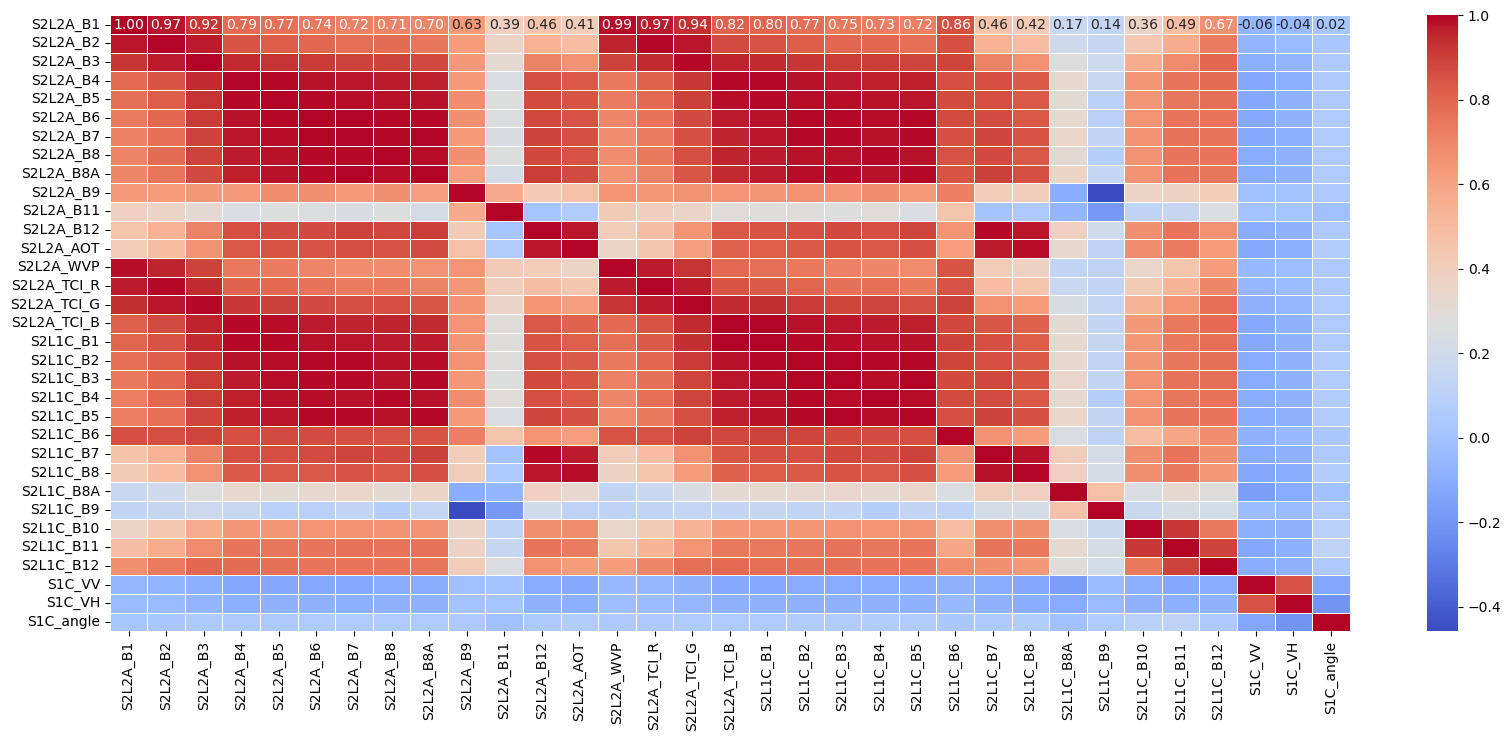

In [14]:
# Visualizing the correlation matrix between the features
features = sampled_data.drop('label', axis=1)

plt.figure(figsize=(20, 8))
sns.heatmap(features.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

We can see that the most correlated features are the first bands from both S2L2A, S2L1C and bands from 4 to 8A from S2L2A.
Therefore we can try to reduce the dimensinality of the data using PCA

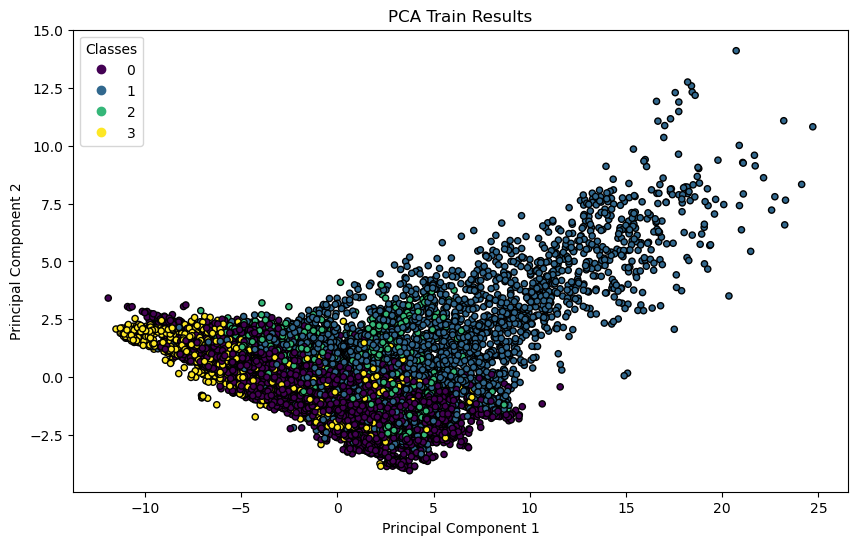

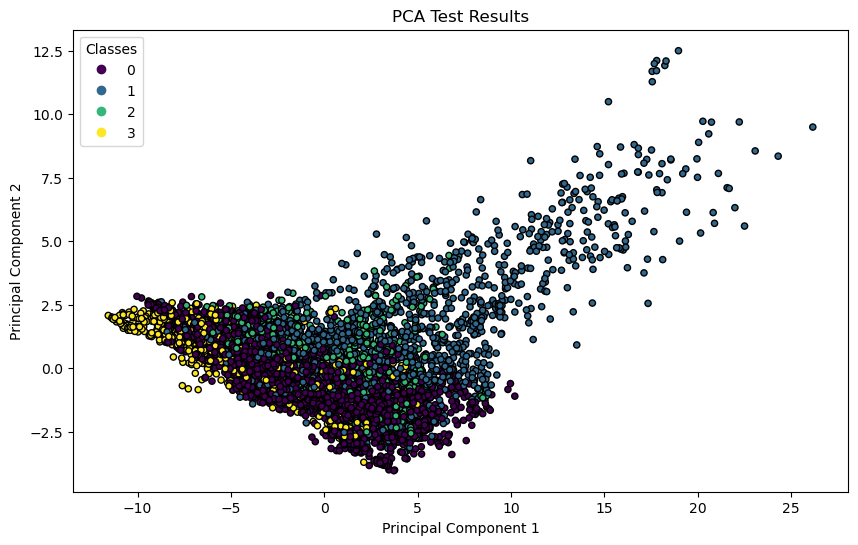

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

features = sampled_data.drop('label', axis=1)

features_train, features_test, y_train, y_test = train_test_split(features, sampled_data['label'], test_size=0.3, random_state=1)
scaler = StandardScaler()
scaled_features_train = scaler.fit_transform(features_train)
scaled_features_test = scaler.transform(features_test)

pca = PCA(n_components = 2)
pca_trained = pca.fit_transform(scaled_features_train)
pca_test = pca.transform(scaled_features_test)


# Now we will display results of the training of PCA
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_trained[:, 0], pca_trained[:, 1], c=y_train, cmap='viridis', edgecolor='k', s=20)
plt.title('PCA Train Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()


# And of the PCA on the test data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_test[:, 0], pca_test[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=20)
plt.title('PCA Test Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.show()

In [17]:
# Change label to binary
sampled_data.loc[:, 'label'] = sampled_data.loc[:, 'label'] > 0

# Change label dtype to int
sampled_data = sampled_data.astype(int)
sampled_data

S2L2A_B1  S2L2A_B2  S2L2A_B3  S2L2A_B4  S2L2A_B5  \
region   image pixel                                                      
ROI_0001 1     249523      1724      1588      1512      1719      1807   
               129866      1634      1410      1376      1559      1667   
               66566       1898      1764      1711      1881      2053   
               243358      1657      1423      1402      1467      1552   
               232615      1580      1367      1325      1473      1489   
...                         ...       ...       ...       ...       ...   
ROI_0023 5     236851      1894      1507      1574      2070      2144   
               228235      2136      2173      2433      2876      2940   
               73129       2225      2632      2768      3102      3188   
               227276      1656      1855      2037      2251      1990   
               107711      2498      2560      2675      3219      3276   

                       S2L2A_B6  S2L2A_B7  S2L2A_B8  S2L2A_B8A  S2L2A_B9  ...  \
region   image pixel                                                      ...   
ROI_0001 1     249523      1978      2091      2084       2234      1193  ...   
               129866      1849      1988      1931       2081      1090  ...   
               66566       2185      2294      2211       2334      1203  ...   
               243358      1720      1836      1835       1918      1079  ...   
               232615      1668      1766      1870       1872      1027  ...   
...                         ...       ...       ...        ...       ...  ...   
ROI_0023 5     236851      2389      2603      1809       2637       976  ...   
               228235      3034      3201      3054       3298      1184  ...   
               73129       3353      3546      3472       3664      1333  ...   
               227276      1938      1974      2419       1939       643  ...   
               107711      3422      3546      3300       3573      1502  ...   

                       S2L1C_B8  S2L1C_B8A  S2L1C_B9  S2L1C_B10  S2L1C_B11  \
region   image pixel                                                         
ROI_0001 1     249523      2500        190       696        179        147   
               129866      2373        190       696        156        124   
               66566       2271        191       696        199        177   
               243358      2062        190       696        145        130   
               232615      1925        190       696        147        119   
...                         ...        ...       ...        ...        ...   
ROI_0023 5     236851      2549        146       942        211        145   
               228235      3234        146      1220        255        255   
               73129       3852        147      1269        255        255   
               227276      1741        146      1578        234        215   
               107711      3701        147      1462        255        255   

                       S2L1C_B12  S1C_VV  S1C_VH  S1C_angle  label  
region   image pixel                                                
ROI_0001 1     249523        122     -26     -16         31      1  
               129866         90     -20     -14         31      0  
               66566         150     -22     -16         31      1  
               243358         93     -17     -12         31      1  
               232615         84     -22     -10         31      1  
...                          ...     ...     ...        ...    ...  
ROI_0023 5     236851        109     -28     -17         42      1  
               228235        217     -26     -19         42      0  
               73129         255     -28     -18         42      1  
               227276        167     -27     -16         42      1  
               107711        255     -21     -22         42      1  

[25900 rows x 34 columns]

# Logistic Regression

In [18]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', RidgeClassifier())])

parameters = {
    'classifier__alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(sampled_data.drop('label', axis=1), sampled_data['label'])

print(f'Accuracy: {grid_search.best_score_:.3}')
print(f'Best parameters: {grid_search.best_params_}')

Accuracy: 0.75
Best parameters: {'classifier__alpha': 1}


# KNN

In [19]:
pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', KNeighborsClassifier())])

parameters = {
    'classifier__n_neighbors': list(range(1, df.shape[1] - 1, 2)),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(sampled_data.drop('label', axis=1), sampled_data['label'])

print(f'Accuracy: {grid_search.best_score_:.3}')
print(f'Best parameters: {grid_search.best_params_}')

Accuracy: 0.639
Best parameters: {'classifier__n_neighbors': 27}


# Random Forest

In [20]:
pipeline = Pipeline([('classifier', RandomForestClassifier())])

parameters = {
    'classifier__n_estimators': [1000],
    # 'classifier__max_depth': list(range(1, 10)),
    'classifier__max_depth': list(range(6, 7)),
    'classifier__min_samples_split': list(range(2, 3)),
    # 'classifier__min_samples_split': list(range(2, 10, 2)),
    'classifier__min_samples_leaf': list(range(3, 4,)),
    # 'classifier__min_samples_leaf': list(range(1, 10, 2)),
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(sampled_data.drop('label', axis=1), sampled_data['label'])

print(f'Accuracy: {grid_search.best_score_:.3}')
print(f'Best parameters: {grid_search.best_params_}')

Accuracy: 0.731
Best parameters: {'classifier__max_depth': 6, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 1000}


In [21]:
final_model = grid_search.best_estimator_

# Load and process test data

In [24]:
df_test = load_all_images(TEST_DATASET_DIRECTORY)
df_test['label'] = df_test['label'] > 0
df_test = df_test.astype(int)
df_test

Loaded 3 Regions Of Interest.


S2L2A_B1  S2L2A_B2  S2L2A_B3  S2L2A_B4  S2L2A_B5  \
region   image pixel                                                      
ROI_0021 1     1           2298      2415      3000      4183      4454   
               2           2304      2352      2949      4083      4390   
               3           2304      2398      3003      4185      4390   
               4           2304      2437      3045      4205      4483   
               5           2304      2428      3023      4214      4483   
...                         ...       ...       ...       ...       ...   
ROI_0023 5     259077      2973      1973      2630      3061      3194   
               259078      2973      2062      2597      3091      3194   
               259079      2371      2099      2513      3086      3064   
               259080      2371      2074      2427      2960      3064   
               259081      2371      2018      2407      2867      2899   

                       S2L2A_B6  S2L2A_B7  S2L2A_B8  S2L2A_B8A  S2L2A_B9  ...  \
region   image pixel                                                      ...   
ROI_0021 1     1           4731      4995      4803       5173      1993  ...   
               2           4679      4945      4740       5145      1991  ...   
               3           4679      4945      4731       5145      1991  ...   
               4           4740      5041      4796       5213      1991  ...   
               5           4740      5041      4846       5213      1991  ...   
...                         ...       ...       ...        ...       ...  ...   
ROI_0023 5     259077      3346      3501      2861       3601      2213  ...   
               259078      3346      3501      2966       3601      2213  ...   
               259079      3170      3312      2849       3334      1515  ...   
               259080      3170      3312      2784       3334      1515  ...   
               259081      3000      3172      2716       3242      1515  ...   

                       S2L1C_B8  S2L1C_B8A  S2L1C_B9  S2L1C_B10  S2L1C_B11  \
region   image pixel                                                         
ROI_0021 1     1           5326        191       807        255        255   
               2           5315        191       807        255        255   
               3           5315        191       807        255        255   
               4           5420        191       817        255        255   
               5           5420        191       817        255        255   
...                         ...        ...       ...        ...        ...   
ROI_0023 5     259077      3721        146       532        255        255   
               259078      3721        146       532        254        254   
               259079      3481        146       613        255        255   
               259080      3481        146       613        255        255   
               259081      3325        146       749        255        255   

                       S2L1C_B12  S1C_VV  S1C_VH  S1C_angle  label  
region   image pixel                                                
ROI_0021 1     1             217     -27     -15         39      0  
               2             207     -27     -17         39      0  
               3             215     -27     -18         39      0  
               4             224     -30     -19         39      0  
               5             222     -37     -12         39      0  
...                          ...     ...     ...        ...    ...  
ROI_0023 5     259077        183     -25     -13         42      1  
               259078        199     -24     -15         42      1  
               259079        204     -22     -16         42      1  
               259080        200     -22     -16         42      1  
               259081        192     -22     -15         42      1  

[3886215 rows x 34 columns]

# Evaluate final model

In [28]:
def evaluate_model(df, model, n_images=2):
    """
    Calculate accuracy and plot confusion matrix on test data.
    """
    if n_images > df.index.levels[0].size:
        print(f"n_images must be less than {df.index.levels[0].size}")
        return
    rois = df.index.levels[0].to_numpy()
    np.random.shuffle(rois)
    rois = rois[:n_images]
    preditions = []
    labels = []
    for roi in rois:
        image_number = np.random.randint(1, IMG_PER_REG + 1)
        pixels = df.loc[roi, image_number, :].drop('label', axis=1)
        prediction = model.predict(pixels)  
        preditions.append(prediction)
        label = df.loc[(roi, image_number), 'label']
        labels.append(label)

    predictions = np.concatenate(preditions)
    labels = np.concatenate(labels)

    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clear', 'Cloud'])
    disp.plot()

    print(f"Accuracy: {np.mean(predictions == labels):.3}")

evaluate_model(df_test, final_model, n_images=20)

n_images must be less than 3


C:\Users\Robert\.conda\envs\ForProject\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.37      0.70      0.48     70614
           1       0.83      0.55      0.66    188467

    accuracy                           0.59    259081
   macro avg       0.60      0.62      0.57    259081
weighted avg       0.70      0.59      0.61    259081



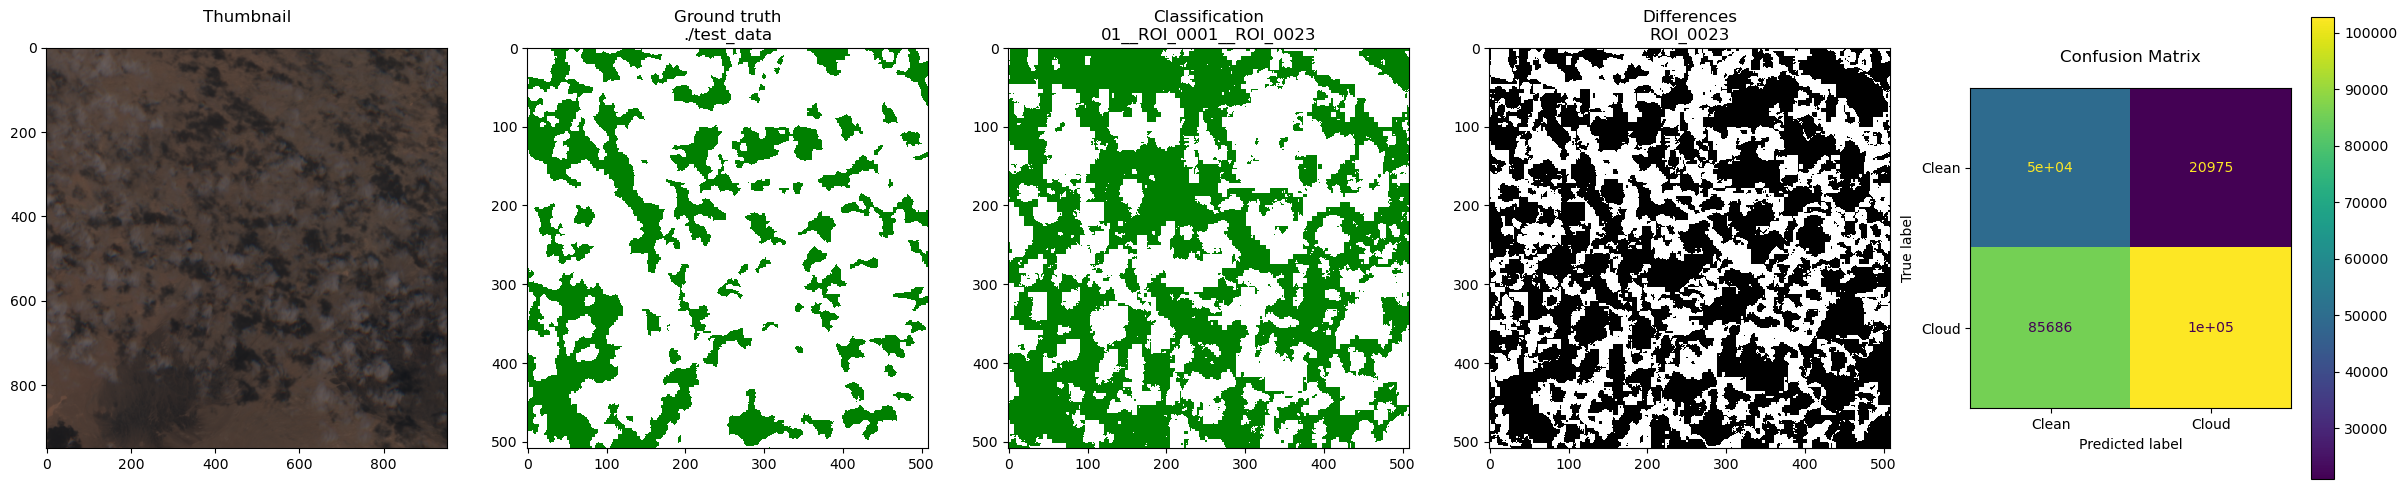

C:\Users\Robert\.conda\envs\ForProject\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.92      1.00      0.96    204796
           1       0.99      0.68      0.81     54285

    accuracy                           0.93    259081
   macro avg       0.95      0.84      0.88    259081
weighted avg       0.94      0.93      0.93    259081



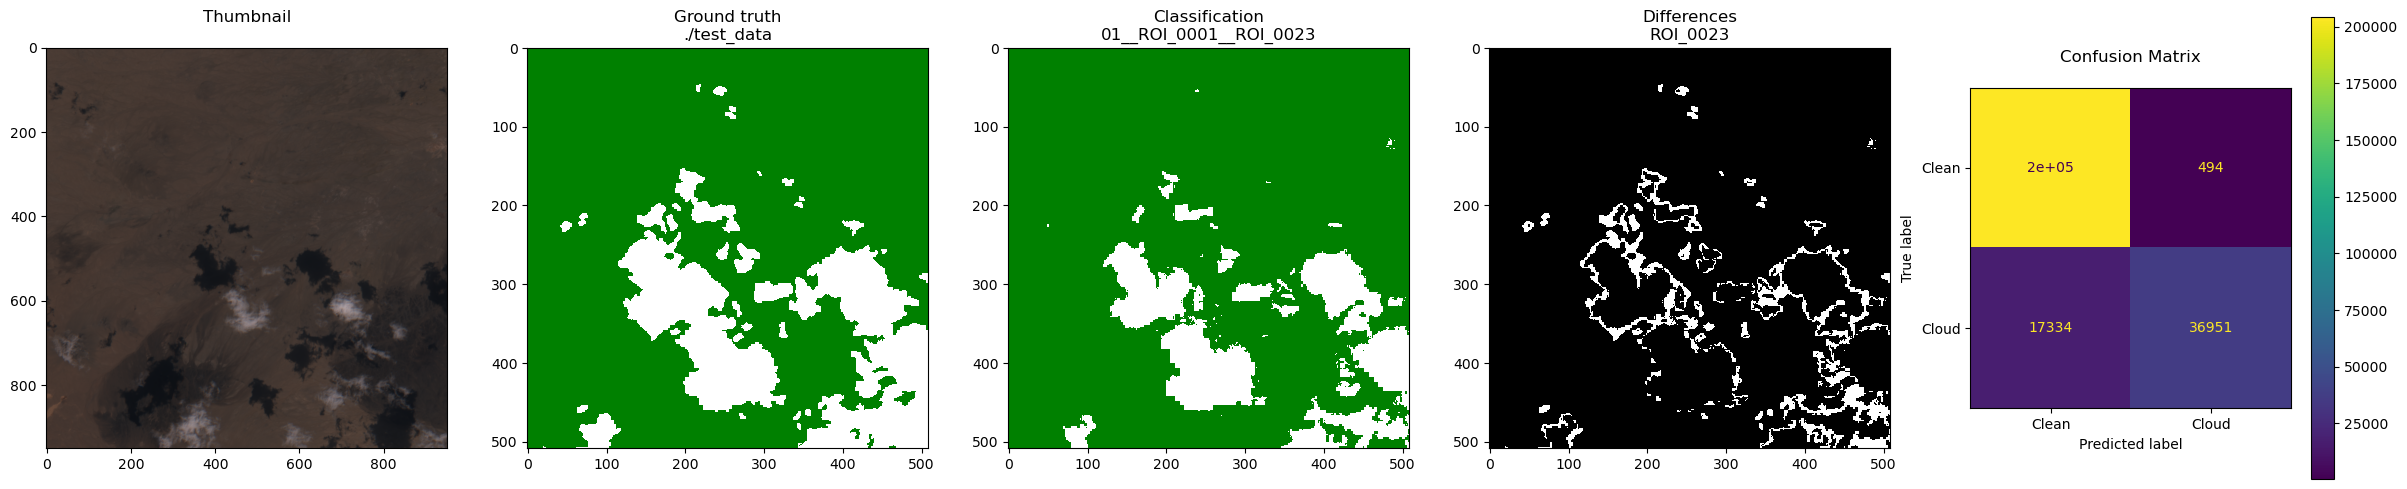

C:\Users\Robert\.conda\envs\ForProject\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.66      0.76    170042
           1       0.57      0.85      0.68     89039

    accuracy                           0.73    259081
   macro avg       0.73      0.76      0.72    259081
weighted avg       0.78      0.73      0.74    259081



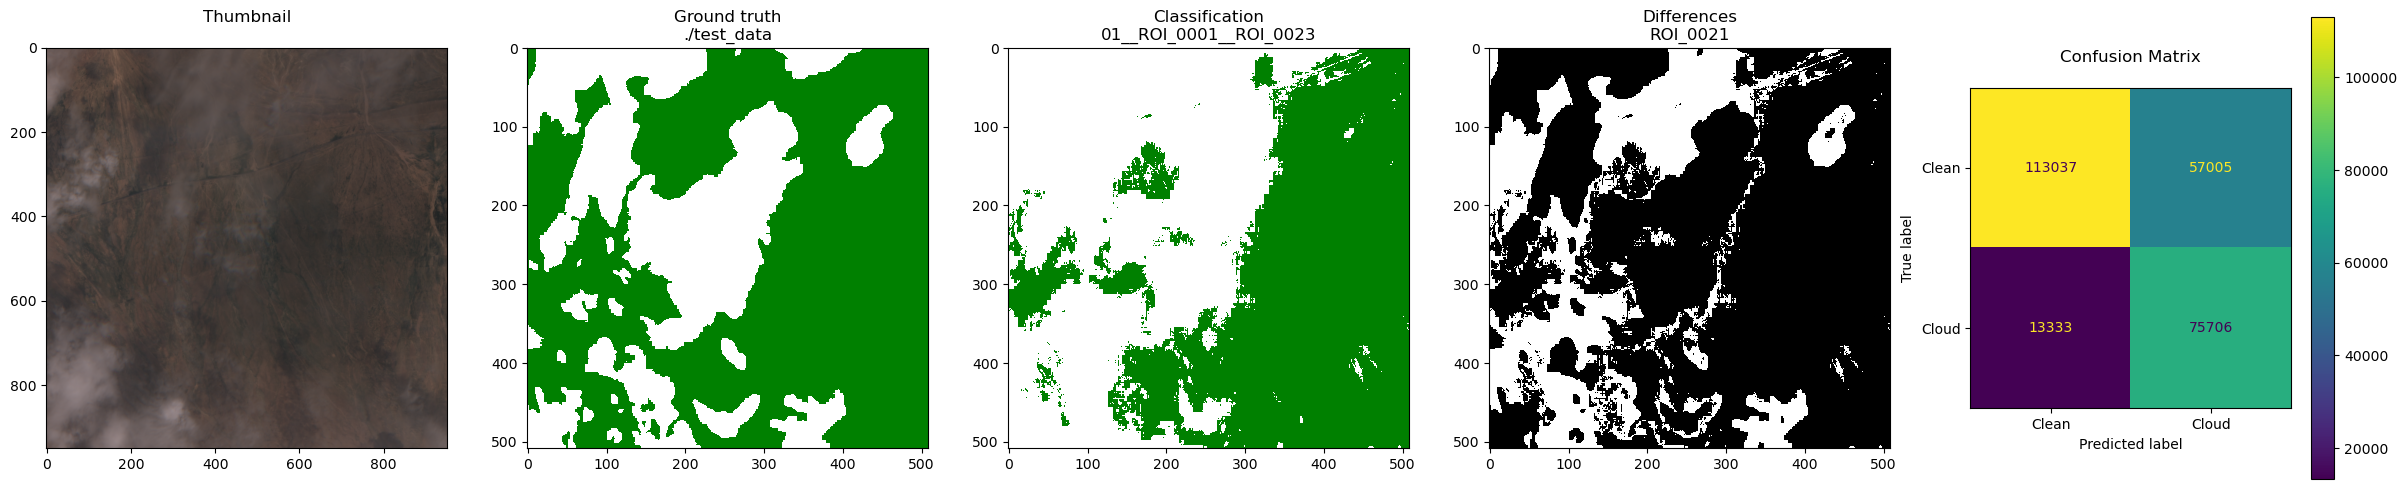

C:\Users\Robert\.conda\envs\ForProject\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.95      0.97      0.96    235710
           1       0.59      0.43      0.50     23371

    accuracy                           0.92    259081
   macro avg       0.77      0.70      0.73    259081
weighted avg       0.91      0.92      0.92    259081



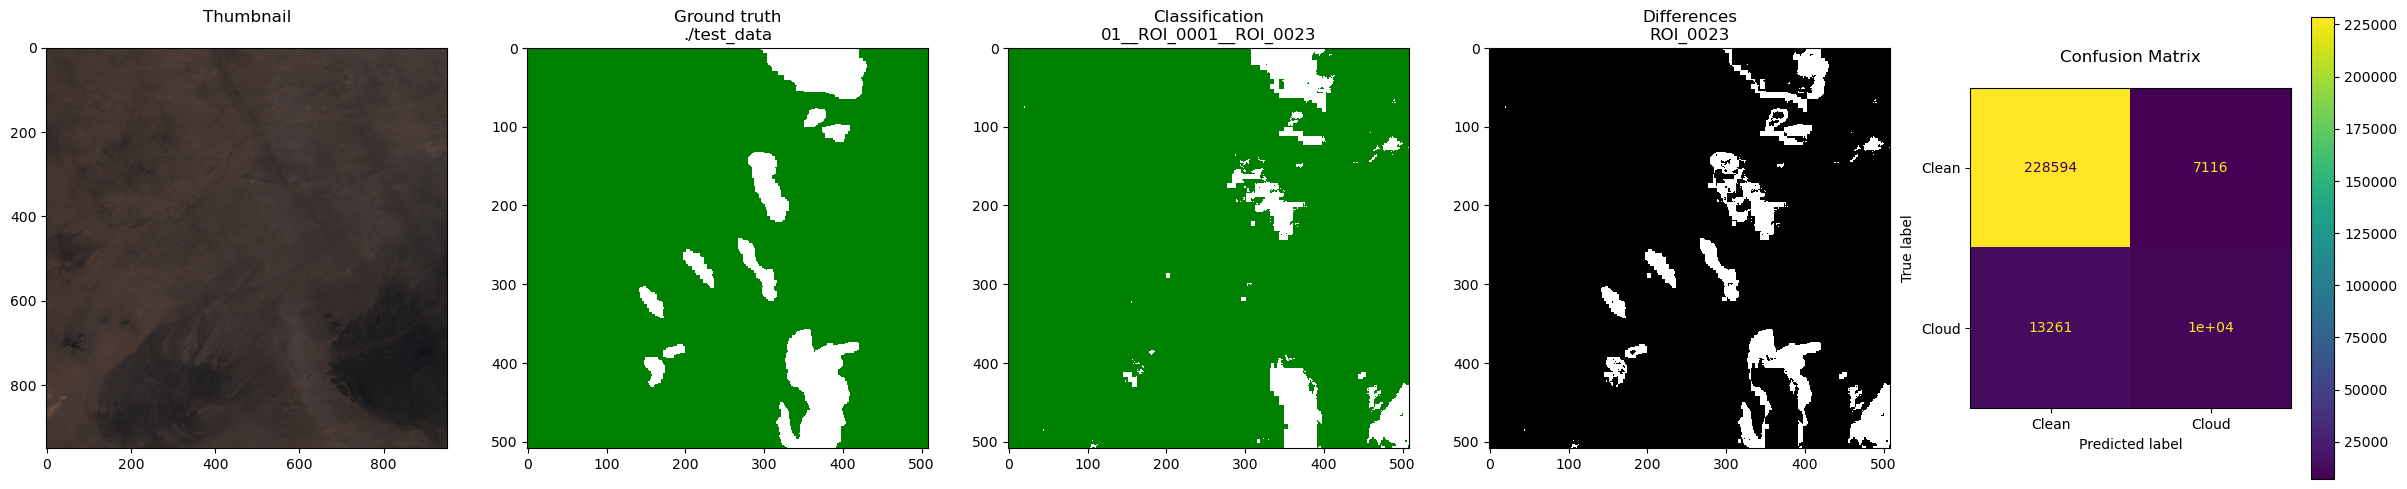

C:\Users\Robert\.conda\envs\ForProject\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.81      0.90      0.85    193422
           1       0.55      0.38      0.45     65659

    accuracy                           0.77    259081
   macro avg       0.68      0.64      0.65    259081
weighted avg       0.75      0.77      0.75    259081



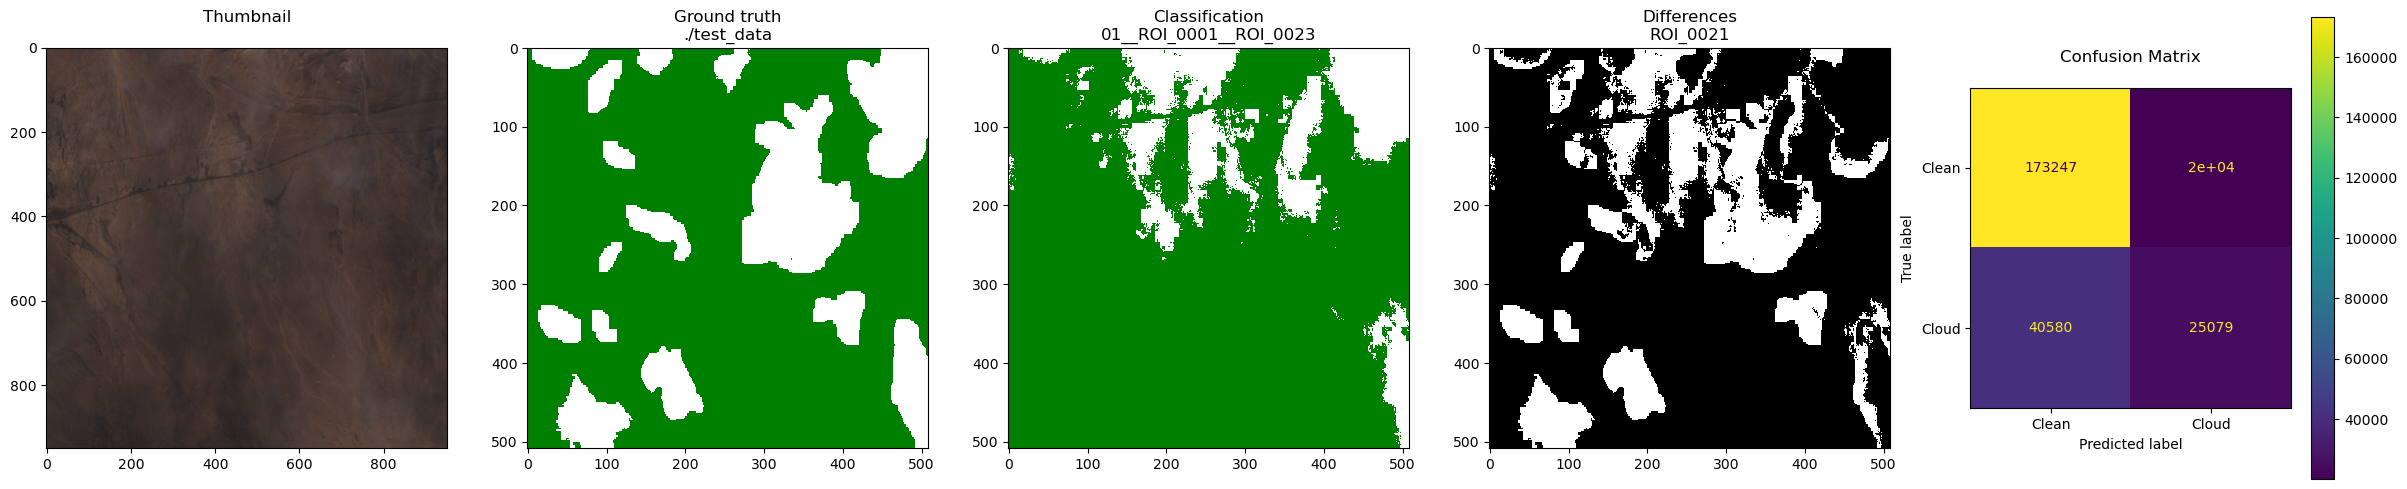

C:\Users\Robert\.conda\envs\ForProject\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.88      1.00      0.94    131556
           1       1.00      0.86      0.92    127525

    accuracy                           0.93    259081
   macro avg       0.94      0.93      0.93    259081
weighted avg       0.94      0.93      0.93    259081



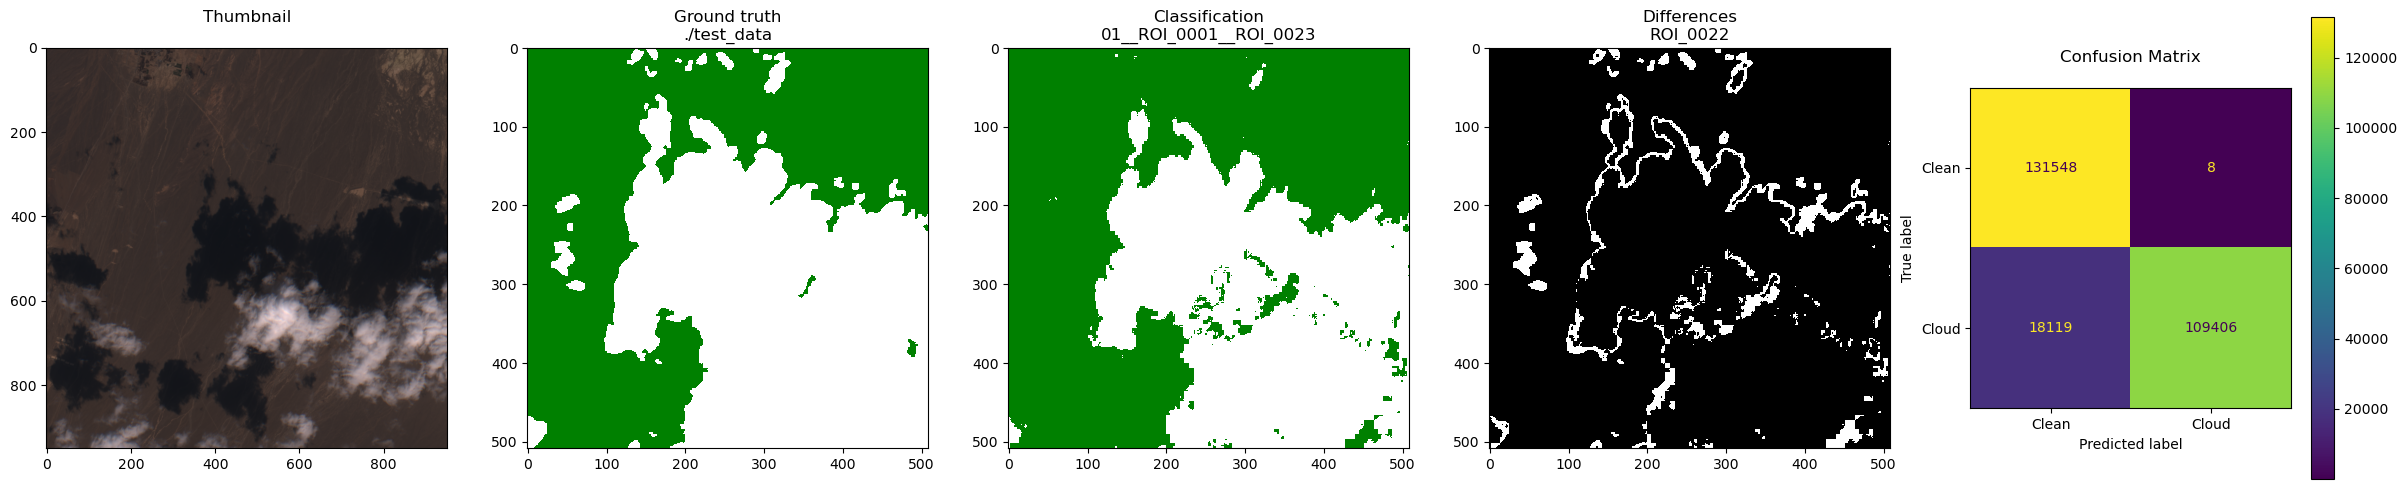

C:\Users\Robert\.conda\envs\ForProject\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    259081
           1       0.00      0.00      0.00         0

    accuracy                           1.00    259081
   macro avg       0.50      0.50      0.50    259081
weighted avg       1.00      1.00      1.00    259081



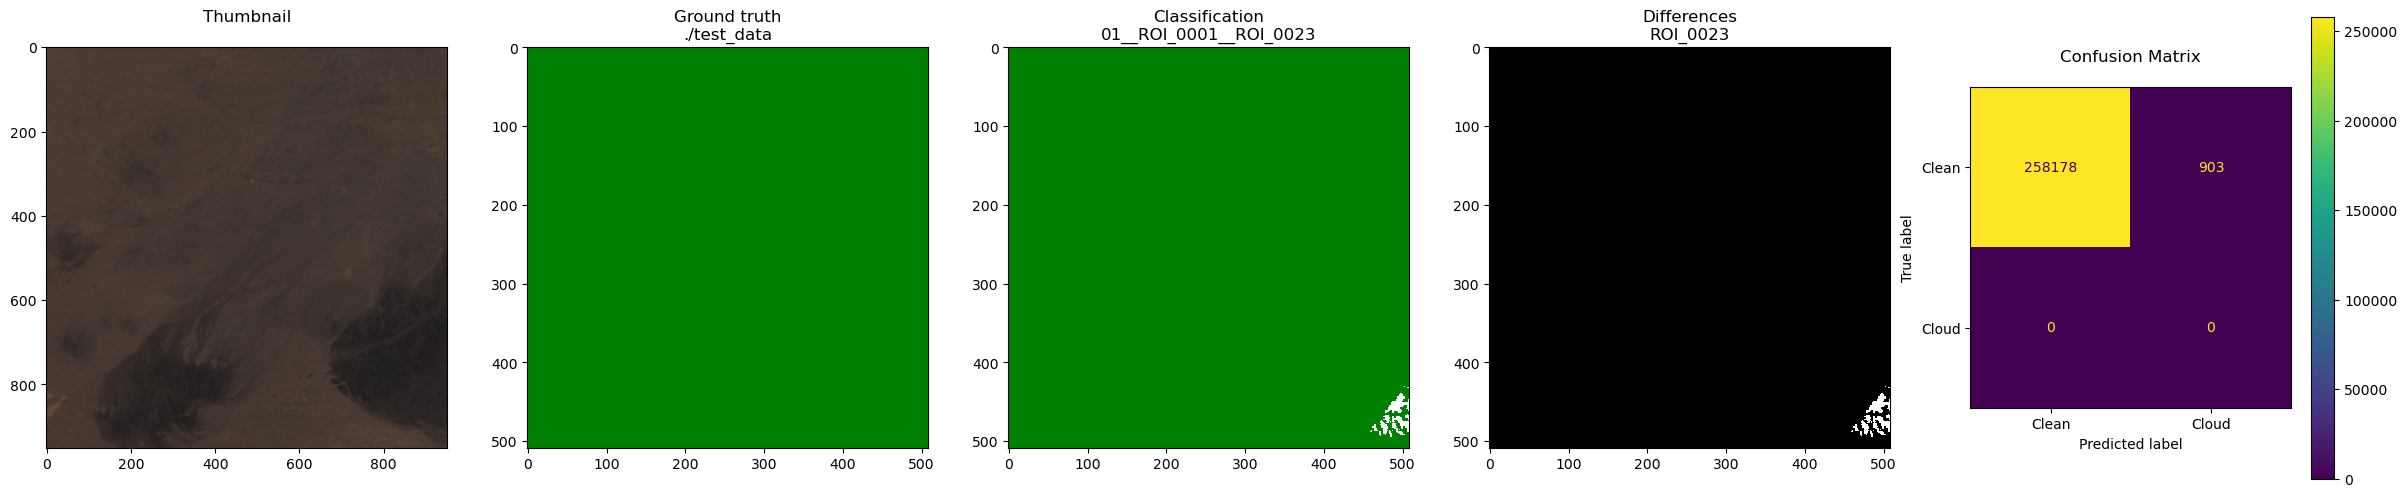

C:\Users\Robert\.conda\envs\ForProject\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.05      0.47      0.09      6750
           1       0.98      0.76      0.86    252331

    accuracy                           0.75    259081
   macro avg       0.52      0.61      0.47    259081
weighted avg       0.96      0.75      0.84    259081



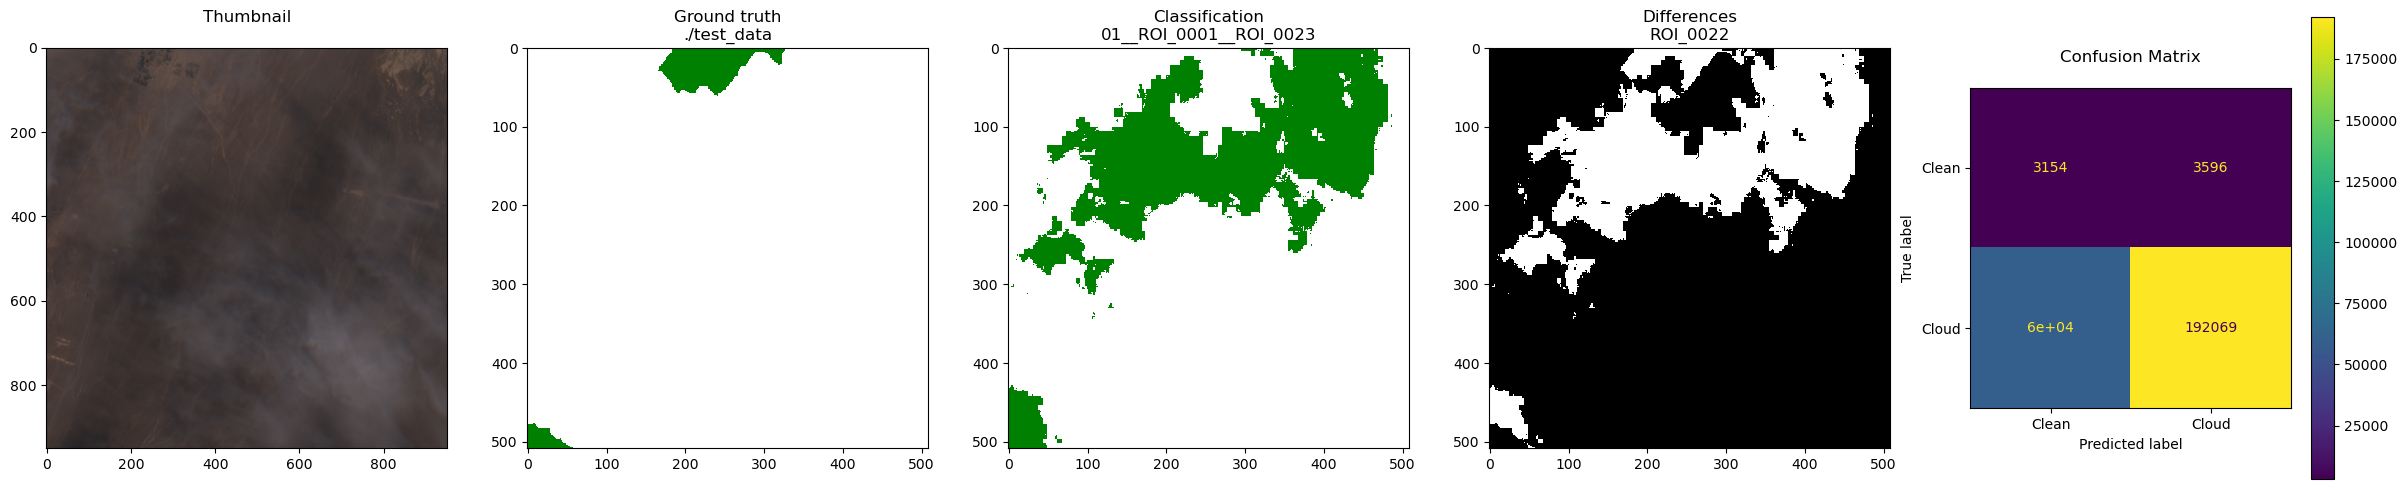

C:\Users\Robert\.conda\envs\ForProject\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.96      0.63      0.76     29625
           1       0.95      1.00      0.97    229456

    accuracy                           0.95    259081
   macro avg       0.96      0.81      0.87    259081
weighted avg       0.95      0.95      0.95    259081



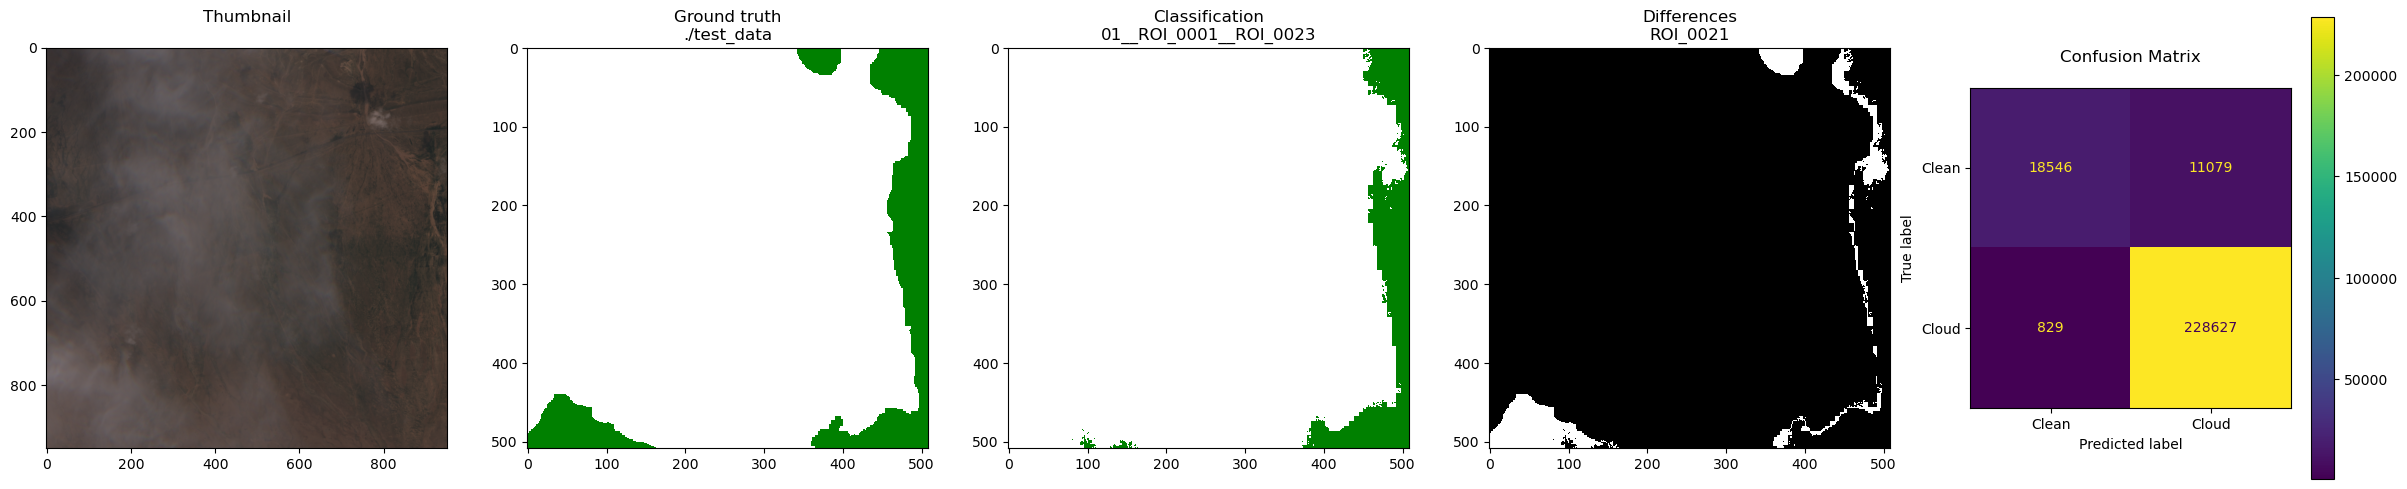

C:\Users\Robert\.conda\envs\ForProject\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.59      0.70      0.64     63763
           1       0.90      0.84      0.87    195318

    accuracy                           0.81    259081
   macro avg       0.74      0.77      0.75    259081
weighted avg       0.82      0.81      0.81    259081



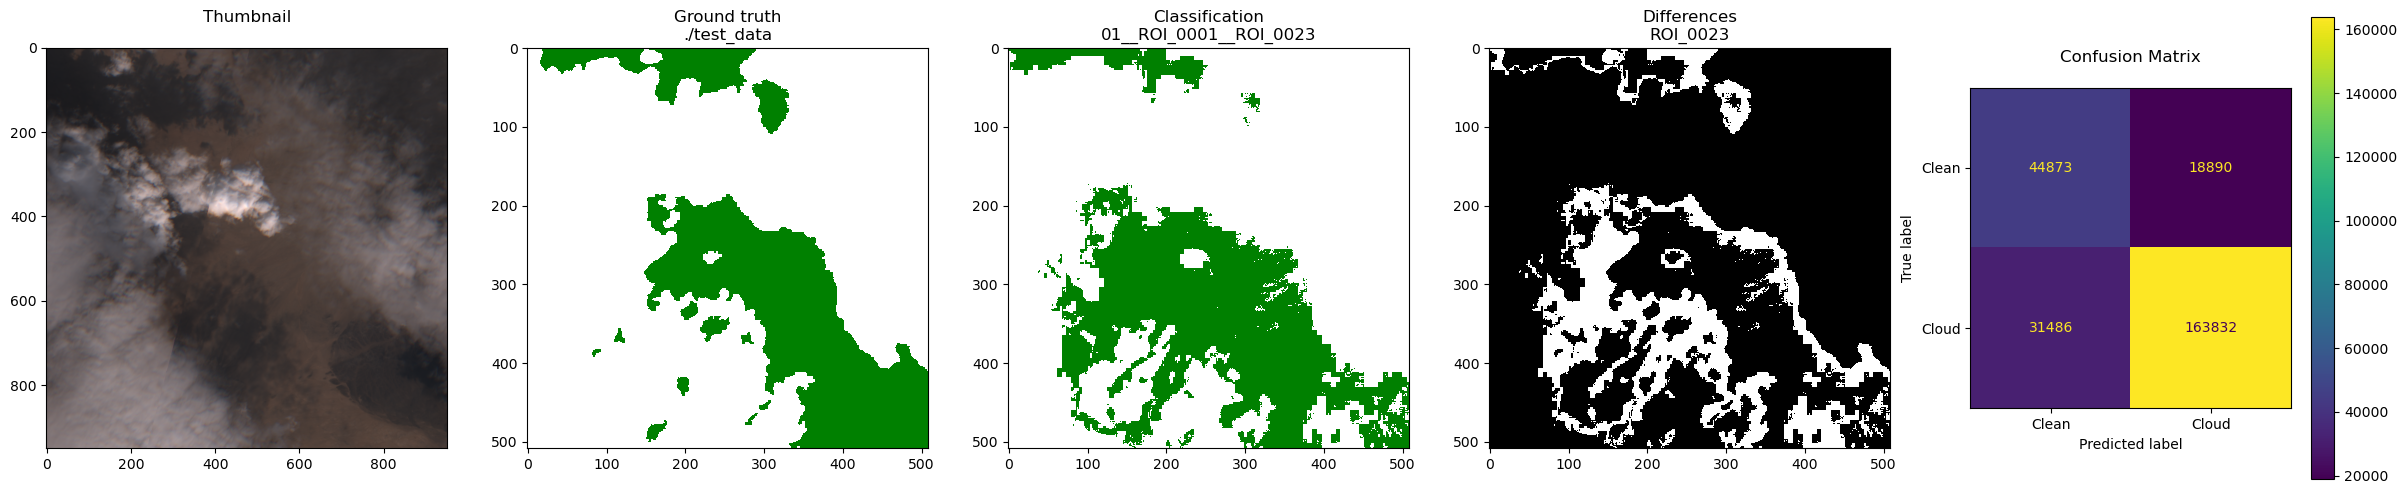

In [29]:
# Color map to show the manual_hq and predicted results    
cmap_clouds, norm_clouds  = matplotlib.colors.from_levels_and_colors(levels=[0.0,1.0,2.0,3.0],colors=['green','white','gray','brown'],extend='max')

# Color map to show the error (white means error)
cmap_diffs, norm_diffs  = matplotlib.colors.from_levels_and_colors(levels=[False,True],colors=['black','white'],extend='max')

test_paths = []
for dir in os.listdir(TEST_DATASET_DIRECTORY):
    for region in os.listdir(TEST_DATASET_DIRECTORY + '/' + dir):
        for image in os.listdir(TEST_DATASET_DIRECTORY + '/' + dir + '/' + region):
            test_paths.append([TEST_DATASET_DIRECTORY, dir, region, image])

np.random.shuffle(test_paths)
test_paths = test_paths[:10]

for path in test_paths:
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 6))
    axs[0].set_title('Thumbnail\n')
    axs[1].set_title('Ground truth\n' + path[0])
    axs[2].set_title('Classification\n' + path[1])
    axs[3].set_title('Differences\n' + path[2])
    axs[4].set_title('Confusion Matrix\n')

    # The rasters to use
    thumbnail = read_image_patch_file(os.path.join(*path, 'thumbnail.tif'))
    features, labels = read_image_data(os.path.join(*path))
    labels = labels > 0
    labels = labels.astype(int)
    manual_hq = labels.reshape(509,509)

    features = np.moveaxis(features, 0, 2)
    features = features.reshape(-1, features.shape[-1])
    # Adapt the following line to use your trained model, and any processing required
    pred_image = final_model.predict(features).reshape(509,509)
    error_matrix = pred_image != manual_hq

    # Show the rasters
    rasterio.plot.show(thumbnail, ax= axs[0] )    
    rasterio.plot.show(manual_hq, ax= axs[1], cmap=cmap_clouds, norm=norm_clouds, interpolation='none')    
    rasterio.plot.show(pred_image, ax= axs[2], cmap=cmap_clouds, norm=norm_clouds, interpolation='none')
    rasterio.plot.show(error_matrix, ax= axs[3], cmap=cmap_diffs, norm=norm_diffs, interpolation='none')

    # Construct the confusion matrix
    cm = confusion_matrix(manual_hq.reshape(509*509,), pred_image.reshape(509*509,), labels=[0, 1])
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Clean', 'Cloud']).plot(ax=axs[4])

    report = classification_report(manual_hq.reshape(509*509,), pred_image.reshape(509*509,), zero_division=0)
    print(report)
    plt.show()